# Classification with CIFAR10 using a basic CNN 

## Requirements:

1. Python 2.7
3. PyTorch
2. NumPy
3. Data: download [cifar-10-python.tar.gz](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and extract as **cifar-10-python**

In [1]:
import numpy as np
import pickle
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES']='1'

### Define network architecture 
#### 3 convolutial layers + 3 fully-connected layers:
* input 
* conv1: input channel = 3, output channel = 32, kernel size = 3, padding to same size
* relu
* maxpooling (kernel size = 2, stride = 2)
* conv2: input channel = 32, output channel = 48, kernel size = 3, padding to same size
* relu
* maxpooling (kernel size = 2, stride = 2)
* conv3: input channel = 48, output channel = 64, kernel size = 3, padding to same size
* relu
* maxpooling (kernel size = 2, stride = 2)
* fc1: input channel = 64*(32/8)^2, output channel = 128
* relu
* fc2: input channel = 128, output channel = 64
* relu
* fc3: input channel = 64, output channel = 10
* softmax on output
* cross entropy loss

In [2]:
##########################
# CNN model
##########################

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding = 1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64*4*4, 128)
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, 10)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Reshape for fully connected layers
        x = x.view(-1, self.num_flat_features(x))

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Define data loader

In [3]:
##########################
# Reading CIFAR10 data
##########################

class cifar_Loader:
    
    def __init__(self):
    
        self.train_data = None
        self.train_labels = None
        for i in range(1, 6):
            pickleFile = self.unpickle('cifar-10-batches-py/data_batch_{}'.format(i))
            dataX = pickleFile[b'data']
            dataY = pickleFile[b'labels']
            if type(self.train_data) is np.ndarray:
                self.train_data = np.concatenate((self.train_data, dataX))
                self.train_labels = np.concatenate((self.train_labels, dataY))
            else:
                self.train_data = dataX
                self.train_labels = dataY
            
        self.train_data = self.train_data.reshape(self.train_data.shape[0], 3, 32, 32)
        self.train_data = self.train_data.transpose([0, 2, 3, 1])
        
        ########################################################
        # Split train and validation via stratified sampling
        ########################################################
        
        np.random.seed(0)
        val_num = int(self.train_data.shape[0]*0.2)
        randord = np.random.permutation(range(self.train_data.shape[0])).tolist()
        self.val_data = self.train_data[randord[:val_num],:,:,:]
        self.val_labels = self.train_labels[randord[:val_num]]
        self.train_data = self.train_data[randord[val_num:],:,:,:]
        self.train_labels = self.train_labels[randord[val_num:]]
        
        self.test_data = None
        self.test_labels = None
        pickleFile = self.unpickle('cifar-10-batches-py/test_batch')
        dataX = pickleFile[b'data']
        dataY = pickleFile[b'labels']
        if type(self.test_data) is np.ndarray:
            self.test_data = np.concatenate((self.test_data, dataX))
            self.test_labels = np.concatenate((self.test_labels, dataY))
        else:
            self.test_data = np.array(dataX)
            self.test_labels = np.array(dataY)

        self.test_data = self.test_data.reshape(self.test_data.shape[0], 3, 32, 32)
        self.test_data = self.test_data.transpose([0, 2, 3, 1])
            
    def unpickle(self,file):
        
        with open(file, 'rb') as fo:
            dict = pickle.load(fo)
        return dict
    
class data_prepare:
    
    def __init__(self, data = None, labels = None, transform = None):        
        self.data = data  
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):        
        img, target = self.data[index], self.labels[index]    
        img = np.float64(img)
        if self.transform is not None:
            img[:,:,0] -= self.transform[0][0]
            img[:,:,0] /= self.transform[0][1]
            img[:,:,1] -= self.transform[1][0]
            img[:,:,1] /= self.transform[1][1]
            img[:,:,2] -= self.transform[2][0]
            img[:,:,2] /= self.transform[2][1]
            
        img = img.transpose([2, 0, 1])
        return torch.FloatTensor(img), target
    
    def __len__(self):        
        return self.data.shape[0]

### Begin loading data from CIFAR10 
* Splitted into training vs. validation vs. test

In [4]:
########################################################
# Loading CIFAR10  
########################################################

cifar = cifar_Loader()
transform = []
transform.append([np.mean(cifar.train_data[:,:,:,0]), np.std(cifar.train_data[:,:,:,0])])
transform.append([np.mean(cifar.train_data[:,:,:,1]), np.std(cifar.train_data[:,:,:,1])])
transform.append([np.mean(cifar.train_data[:,:,:,2]), np.std(cifar.train_data[:,:,:,2])])

# prepare training data
cifar_train = data_prepare(data = cifar.train_data, labels = cifar.train_labels, transform=transform)
# prepare validation data
cifar_val = data_prepare(data = cifar.val_data, labels = cifar.val_labels, transform=transform)
# prepare test data
cifar_test = data_prepare(data = cifar.test_data, labels = cifar.test_labels, transform=transform)

print("training data: {}".format(cifar_train.data.shape))
print("training label: {}".format(cifar_train.labels.shape))
print("validation data: {}".format(cifar_val.data.shape))
print("validation label: {}".format(cifar_val.labels.shape))
print("test data: {}".format(cifar_test.data.shape))
print("test label: {}".format(cifar_test.labels.shape))

training data: (40000, 32, 32, 3)
training label: (40000,)
validation data: (10000, 32, 32, 3)
validation label: (10000,)
test data: (10000, 32, 32, 3)
test label: (10000,)


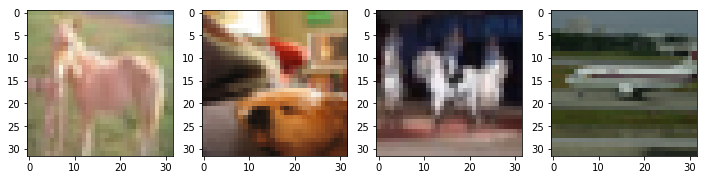

In [5]:
########################################################
# Visualize a few sample images  
########################################################
plt.figure(figsize=(12, 5))
for n_img in range(1,5):
    plt.subplot(1,4,n_img)
    plt.imshow(cifar_train.data[n_img])

### Begin training

In [6]:
# Hyperparameters
n_epochs = 200
n_verbose = 10
batch_size = 200
learning_rate = 0.001
momentum = 0.9

# Define Model
model = Model()
model = model.cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Prepare data loader
loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=True, num_workers=2)

# Begin iteration

LOSS_train = np.zeros(n_epochs)
LOSS_val = np.zeros(n_epochs)
ACC_train = np.zeros(n_epochs)
ACC_val = np.zeros(n_epochs)
history_loss_best = 10**6
history_tolerance = 0
best_epoch = 0

for epoch in range(n_epochs): 
     
    # training
    loss_train = []
    correct = 0
    total = 0
    for data in loader_train:
        # prepare data in minibatch
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        images, labels_var = Variable(images), Variable(labels)
        
        # Train on minibatch: initialize grad. - forward - loss - backward - update grad.
        optimizer.zero_grad()              
        outputs = model(images)            
        loss = criterion(outputs, labels_var)  
        loss.backward()                    
        optimizer.step()                  
        
        loss_train.append(loss.data[0])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    LOSS_train[epoch] = sum(loss_train)/len(loss_train)
    ACC_train[epoch] = correct * 100./ total
        
    # validation
    loss_val = []
    correct = 0
    total = 0
    for data in loader_val:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        images, labels_var = Variable(images), Variable(labels)
        outputs = model(images)
        loss = criterion(outputs, labels_var)        
        loss_val.append(loss.data[0])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    LOSS_val[epoch] = sum(loss_val)/len(loss_val)
    ACC_val[epoch] = correct * 100./ total
    
    if epoch > 50 and LOSS_val[epoch] < history_loss_best and history_tolerance <= 10:
        torch.save(model.state_dict(), './model_1.1.pt')
        history_loss_best = LOSS_val[epoch] 
        history_tolerance = 0
        best_epoch = epoch
        
        print("Epoch {} / {} Train loss {:.2f} accuracy {:.2f}% | Validation loss {:.2f} accuracy {:.2f}% best model detected!".format(
        epoch, n_epochs, LOSS_train[epoch], ACC_train[epoch], LOSS_val[epoch], ACC_val[epoch]))        
    else:
        if epoch > 50:
            history_tolerance += 1
        
        if epoch % n_verbose == 0:
            print("Epoch {} / {} Train loss {:.2f} accuracy {:.2f}% | Validation loss {:.2f} accuracy {:.2f}% ".format(
            epoch, n_epochs, LOSS_train[epoch], ACC_train[epoch], LOSS_val[epoch], ACC_val[epoch]))

print("Best model detected at epoch {} / {}".format(best_epoch, n_epochs))

Epoch 0 / 200 Train loss 2.30 accuracy 9.90% | Validation loss 2.30 accuracy 10.40% 
Epoch 10 / 200 Train loss 1.58 accuracy 41.64% | Validation loss 1.56 accuracy 42.07% 
Epoch 20 / 200 Train loss 1.29 accuracy 53.32% | Validation loss 1.28 accuracy 54.04% 
Epoch 30 / 200 Train loss 1.08 accuracy 61.66% | Validation loss 1.10 accuracy 60.32% 
Epoch 40 / 200 Train loss 0.90 accuracy 68.28% | Validation loss 0.98 accuracy 65.74% 
Epoch 50 / 200 Train loss 0.77 accuracy 73.00% | Validation loss 0.89 accuracy 68.86% 
Epoch 51 / 200 Train loss 0.76 accuracy 73.55% | Validation loss 0.90 accuracy 68.75% best model detected!
Epoch 52 / 200 Train loss 0.75 accuracy 73.77% | Validation loss 0.87 accuracy 69.57% best model detected!
Epoch 56 / 200 Train loss 0.70 accuracy 75.60% | Validation loss 0.87 accuracy 70.27% best model detected!
Epoch 58 / 200 Train loss 0.68 accuracy 76.48% | Validation loss 0.86 accuracy 70.48% best model detected!
Epoch 60 / 200 Train loss 0.66 accuracy 77.03% | Val

### Plot training vs. validation loss and accuracy

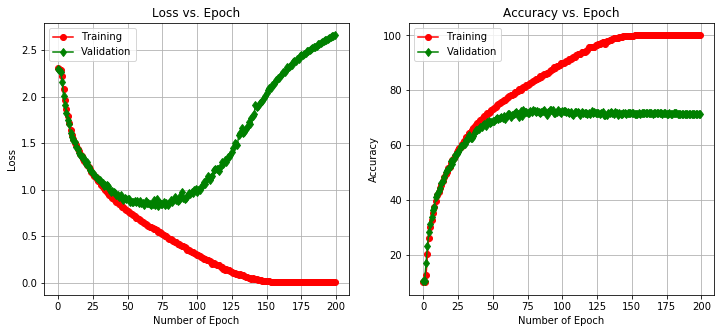

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(range(n_epochs), LOSS_train, 'ro-', label='Training')
plt.plot(range(n_epochs), LOSS_val, 'gd-', label='Validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(range(n_epochs), ACC_train, 'ro-', label='Training')
plt.plot(range(n_epochs), ACC_val, 'gd-', label='Validation')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

### Test result

In [8]:
# test
model.load_state_dict(torch.load('./model_1.1.pt'))
loss_test = []
correct = 0
total = 0
for data in loader_test:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    images, labels_var = Variable(images), Variable(labels)
    outputs = model(images)
    loss = criterion(outputs, labels_var)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    loss_test.append(loss.data[0])

print("Test loss = {}".format(sum(loss_test)/len(loss_test)))
print("Test accuracy = {:.2f}%".format(correct * 100./ total))

Test loss = 0.828862677813
Test accuracy = 72.40%
